In [1]:
import platform
platform.python_version()

'3.10.11'

In [2]:
import os,csv,re, time
import pickle
import random
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy import stats
from scipy.sparse import issparse
import scanpy as sc
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import cv2
import TESLA as tesla
from IPython.display import Image
import matplotlib.image as mpimg

In [3]:
import scanpy as sc
import pandas as pd
import json
import numpy as np
from PIL import Image
import os

def load_fresh_visium_with_annotations(sample_id='KC1'):
    """
    Load fresh Visium data from H5 files with spatial information and annotations
    """
    
    # Read the H5 file
    if sample_id in ['KC1', 'KC2', 'KC3', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5']:
        h5_path = f'/data/Datasets/Annotated/TLS_VISIUM/h5/{sample_id}_filtered_feature_bc_matrix.h5'
    else:
        h5_path = f'/data/Tools/RESEPT/10x_Visium/{sample_id}/filtered_feature_bc_matrix.h5'
    adata = sc.read_10x_h5(h5_path, gex_only=True)
    adata.var_names_make_unique()
    
    print(f"Loaded count matrix: {adata.shape}")
    
    # Load spatial information
    # spatial_dir = f'/data/Datasets/Annotated/TLS_VISIUM/10x_Visium/{sample_id}/spatial/'
    spatial_dir = f'/data/Tools/RESEPT/10x_Visium/{sample_id}/spatial/'
    if sample_id in ['KC1', 'KC2', 'KC3', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5']:
        # Load tissue positions
        positions = pd.read_csv(
            os.path.join(spatial_dir, 'tissue_positions_list.csv'),
            index_col='barcode'
        )
    else:
        positions = pd.read_csv(
            os.path.join(spatial_dir, 'tissue_positions_list.csv'), header = None,
            index_col=0, names=['in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres']
        )
        
    
    # Load scale factors
    with open(os.path.join(spatial_dir, 'scalefactors_json.json'), 'r') as f:
        scalefactors = json.load(f)
    
    # Set up spatial structure
    adata.uns['spatial'] = {}
    adata.uns['spatial'][sample_id] = {
        'images': {},
        'scalefactors': scalefactors,
        'metadata': {
            'chemistry_description': 'Visium_v1',
            'software_version': 'spaceranger'
        }
    }
    
    # Add spatial information to observations
    adata.obs = adata.obs.join(positions, how='left')
    
    # Add spatial coordinates
    adata.obsm['spatial'] = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].values
    
    # Load images with correct key names
    img_path = os.path.join(spatial_dir, 'tissue_hires_image.png')
    if os.path.exists(img_path):
        img = Image.open(img_path)
        adata.uns['spatial'][sample_id]['images']['hires'] = np.array(img)
    
    img_path = os.path.join(spatial_dir, 'tissue_lowres_image.png')
    if os.path.exists(img_path):
        img = Image.open(img_path)
        adata.uns['spatial'][sample_id]['images']['lowres'] = np.array(img)
    
    # Load high-resolution TIF
    tif_path = f'/data/Datasets/Annotated/TLS_VISIUM_USZ/tif_slides/{sample_id}.tif'
    if os.path.exists(tif_path):
        tif_img = Image.open(tif_path)
        adata.uns['spatial'][sample_id]['images']['fullres'] = np.array(tif_img)
    
    # Filter to spots in tissue first
    adata = adata[adata.obs['in_tissue'] == 1].copy()
    print(f"Shape after filtering to in-tissue spots: {adata.shape}")
    
    # Load your saved annotations
    annotation_path = f"/data/Tools/RESEPT/10x_Visium/{sample_id}/{sample_id}_annotation.csv"
    if os.path.exists(annotation_path):
        print(f"Loading annotations from {annotation_path}")
        annotations = pd.read_csv(annotation_path, index_col=0)
        
        # Get annotation columns (exclude spatial/technical columns)
        annotation_cols = ['manual_anno', 'manual_anno_tls', 'aestetik_manual_anno', 
                          'aestetik_manual_anno_tls', 'ground_truth', 'blur_score']
        
        available_annotation_cols = [col for col in annotation_cols if col in annotations.columns]
        print(f"Found annotation columns: {available_annotation_cols}")
        
        # Add annotations to adata.obs
        for col in available_annotation_cols:
            # Match by barcode index
            matched_values = annotations.reindex(adata.obs.index)[col]
            adata.obs[col] = matched_values
            non_null_count = sum(~matched_values.isna())
            print(f"  {col}: {non_null_count} spots annotated")
    else:
        print(f"No annotation file found at {annotation_path}")
    
    print(f"Final shape: {adata.shape}")
    print(f"Available images: {list(adata.uns['spatial'][sample_id]['images'].keys())}")
    print(f"Annotation columns: {[col for col in adata.obs.columns if 'manual' in col or col in ['ground_truth', 'blur_score']]}")
    
    return adata

In [4]:
# Load a sample with annotations
sample = 'LC4'
sample_id = sample
counts = load_fresh_visium_with_annotations(sample)

Loaded count matrix: (3009, 17845)
Shape after filtering to in-tissue spots: (3009, 17845)
Loading annotations from /data/Tools/RESEPT/10x_Visium/LC4/LC4_annotation.csv
Found annotation columns: []
Final shape: (3009, 17845)
Available images: ['hires', 'lowres']
Annotation columns: []


In [12]:
#Read in gene expression and spatial location
#counts=sc.read("/data/Datasets/Annotated/TLS_VISIUM/h5ad_preprocessed/KC1.h5ad")
#Read in hitology image
img=cv2.imread(f"/data/Datasets/Annotated/TLS_VISIUM/10x_Visium/{sample}/spatial/tissue_hires_image.png")
# img=cv2.imread(f"/data/Datasets/Annotated/TLS_VISIUM/tif_slides/{sample}.tif")

In [11]:
#img = counts.uns['spatial'][sample]['images']['hires']
from scipy.sparse import issparse

# Get scale factor
resize_factor = counts.uns['spatial'][s/ample]['scalefactors']['tissue_hires_scalef']
resize_width = int(img.shape[1] * resize_factor)
resize_height = int(img.shape[0] * resize_factor)

# Preprocessing (do this only once)
counts.var.index = [i.upper() for i in counts.var.index]
counts.var_names_make_unique()
counts.raw = counts
sc.pp.log1p(counts) # impute on log scale
if issparse(counts.X):
    counts.X = counts.X.toarray()

# Scale coordinates to match hires image size
hires_scale = counts.uns['spatial'][sample]['scalefactors']['tissue_hires_scalef']
counts.obs['pixel_y'] = counts.obs['pxl_col_in_fullres'] * hires_scale
counts.obs['pixel_x'] = counts.obs['pxl_row_in_fullres'] * hires_scale
counts.obs['array_y'] = counts.obs['array_col']
counts.obs['array_x'] = counts.obs['array_row']

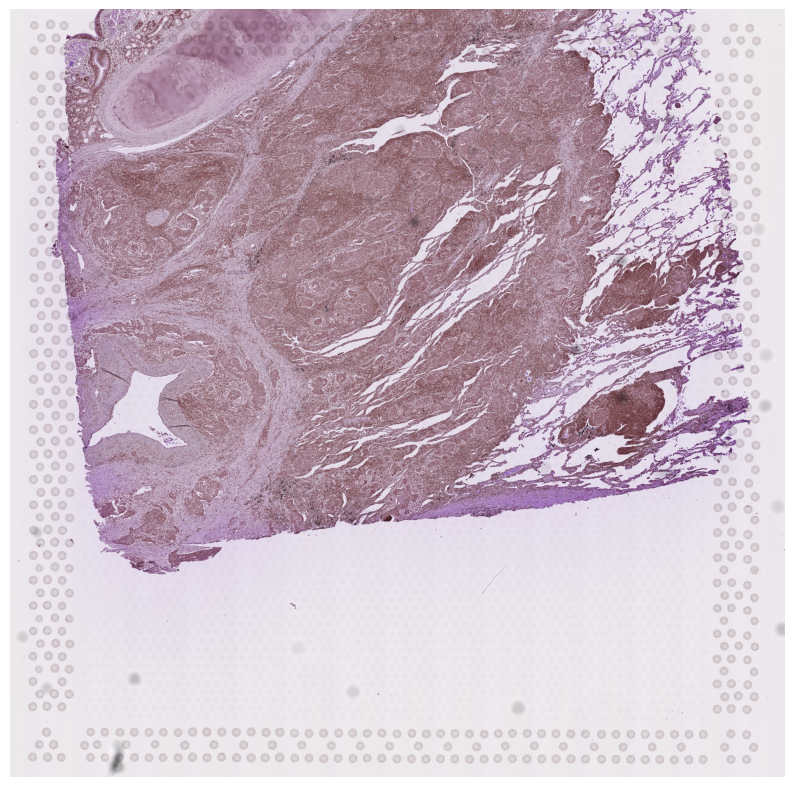

In [14]:
# Rest of your contour detection code...
spots = counts.obs.loc[:, ['pixel_x', 'pixel_y', "array_x", "array_y"]]
cnt = tesla.scan_contour(spots, scan_x=True, shape="hexagon")

binary = np.zeros((img.shape[0:2]), dtype=np.uint8)
cv2.drawContours(binary, [cnt], -1, (1), thickness=-1)

cnt_enlarged = tesla.scale_contour(cnt, 1.05)
binary_enlarged = np.zeros(img.shape[0:2])
cv2.drawContours(binary_enlarged, [cnt_enlarged], -1, (1), thickness=-1)

img_new = img.copy()
cv2.drawContours(img_new, [cnt], -1, (255), thickness=50)
img_new = cv2.resize(img_new, (resize_width, resize_height))
cv2.imwrite('./results/cnt.png', img_new)

plt.figure(figsize=(10, 10))
plt.imshow(img_new)
plt.axis('off')
plt.show()

In [ ]:
#Set size of superpixel
res=20
# Note, if the numer of superpixels is too large and take too long, you can increase the res to 100
enhanced_exp_adata=tesla.imputation(img=img, raw=counts, cnt=cnt, genes=counts.var.index.tolist(), shape="None", res=res, s=1, k=2, num_nbs=10)

In [ ]:
cnt_color = clr.LinearSegmentedColormap.from_list('magma', ["#000003",  "#3b0f6f",  "#8c2980",   "#f66e5b", "#fd9f6c", "#fbfcbf"], N=256)
g="CA9"
enhanced_exp_adata.obs[g]=enhanced_exp_adata.X[:,enhanced_exp_adata.var.index==g]
fig=sc.pl.scatter(enhanced_exp_adata,alpha=1,x="y",y="x",color=g,color_map=cnt_color,show=False,size=100)
fig.set_aspect('equal', 'box')
fig.invert_yaxis()
plt.gcf().set_dpi(600)
fig.figure.show()

In [ ]:
import pickle
import matplotlib.colors as clr

def convert_cluster_density(c_m):
    """Convert list of tuples to dictionary format"""
    if isinstance(c_m, list) and len(c_m) > 0 and isinstance(c_m[0], tuple):
        return {int(cluster_id): float(density) for cluster_id, density in c_m}
    return c_m  # Return as-is if already in correct format
    
# Create results directory
import os
os.makedirs('./results', exist_ok=True)
img_01 = img
# 1. B cell annotation
print("Generating B cell annotation...")
b_cell_genes = ['CD19', 'CD20', 'MS4A1', 'PAX5', 'CD79A', 'CD79B', 'IGHM', 'IGHD']
# Filter available genes
b_genes_available = [g for g in b_cell_genes if g in enhanced_exp_adata.var.index]
print(f"Available B cell genes: {b_genes_available}")

if len(b_genes_available) >= 2:
    pred_refined_b, target_clusters_b, c_m_b = tesla.annotation(
        img=img_01, 
        binary=binary,
        sudo_adata=enhanced_exp_adata, 
        genes=b_genes_available, 
        resize_factor=resize_factor,
        target_size="small",
        min_UMI=0
    )
    # Save results
    np.save(f'./results/{sample_id}_B_annotation.npy', pred_refined_b)
    with open(f'./results/{sample_id}_B_annotation_c_d.pkl', 'wb') as f:
        pickle.dump(convert_cluster_density(c_m_b), f)

# 2. CD4+ T cell annotation
print("Generating CD4+ T cell annotation...")
cd4_genes = ['CD4', 'CD3E', 'CD3D', 'IL7R', 'LEF1', 'CCR7', 'LTB', 'FOXP3']
cd4_genes_available = [g for g in cd4_genes if g in enhanced_exp_adata.var.index]
print(f"Available CD4+ T cell genes: {cd4_genes_available}")

if len(cd4_genes_available) >= 2:
    pred_refined_cd4, target_clusters_cd4, c_m_cd4 = tesla.annotation(
        img=img_01, 
        binary=binary,
        sudo_adata=enhanced_exp_adata, 
        genes=cd4_genes_available, 
        resize_factor=resize_factor,
        target_size="small",
        min_UMI=0
    )
    np.save(f'./results/{sample_id}_CD4+T_annotation.npy', pred_refined_cd4)
    with open(f'./results/{sample_id}_CD4+T_annotation_c_d.pkl', 'wb') as f:
        pickle.dump(convert_cluster_density(c_m_cd4), f)

# 3. Dendritic cell annotation
print("Generating DC annotation...")
dc_genes = ['CD1C', 'FCER1A', 'CLEC9A', 'CD141', 'THBD', 'XCR1', 'CLEC10A', 'CD1A']
dc_genes_available = [g for g in dc_genes if g in enhanced_exp_adata.var.index]
print(f"Available DC genes: {dc_genes_available}")

if len(dc_genes_available) >= 2:
    pred_refined_dc, target_clusters_dc, c_m_dc = tesla.annotation(
        img=img_01, 
        binary=binary,
        sudo_adata=enhanced_exp_adata, 
        genes=dc_genes_available, 
        resize_factor=resize_factor,
        target_size="small",
        min_UMI=0
    )
    np.save(f'./results/{sample_id}_DC_annotation.npy', pred_refined_dc)
    with open(f'./results/{sample_id}_DC_annotation_c_d.pkl', 'wb') as f:
        pickle.dump(convert_cluster_density(c_m_dc), f)

# 4. CXCL13 annotation (important for TLS)
print("Generating CXCL13 annotation...")
cxcl13_genes = ['CXCL13', 'CXCR5', 'BCL6', 'ICOS', 'PDCD1']  # TLS-associated genes
cxcl13_genes_available = [g for g in cxcl13_genes if g in enhanced_exp_adata.var.index]
print(f"Available CXCL13/TLS genes: {cxcl13_genes_available}")

if len(cxcl13_genes_available) >= 1:
    pred_refined_cxcl13, target_clusters_cxcl13, c_m_cxcl13 = tesla.annotation(
        img=img_01, 
        binary=binary,
        sudo_adata=enhanced_exp_adata, 
        genes=cxcl13_genes_available, 
        resize_factor=resize_factor,
        target_size="small",
        min_UMI=0
    )
    np.save(f'./results/{sample_id}_CXCL13_annotation.npy', pred_refined_cxcl13)
    with open(f'./results/{sample_id}_CXCL13_annotation_c_d.pkl', 'wb') as f:
        pickle.dump(convert_cluster_density(c_m_cxcl13), f)

In [ ]:
ret_img=tesla.visualize_annotation(img=img, 
                              binary=binary, 
                              resize_factor=resize_factor,
                              pred_refined=pred_refined_cxcl13, 
                              target_clusters=target_clusters_cxcl13, 
                              c_m=c_m_cxcl13)


cv2.imwrite(f'./results/{sample_id}_cxcl13.jpg', ret_img)
img = mpimg.imread(f'./results/{sample_id}_cxcl13.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
cnt_color = clr.LinearSegmentedColormap.from_list('red', ["#EAE7CC", '#BA0000'], N=256)
pred_refined1=np.load(f"./results/{sample_id}_B_annotation.npy")
pred_refined2=np.load(f"./results/{sample_id}_CD4+T_annotation.npy")
pred_refined3=np.load(f"./results/{sample_id}_DC_annotation.npy")
pred_refined4=np.load(f"./results/{sample_id}_CXCL13_annotation.npy")
pred_refined_list=[pred_refined1, pred_refined2, pred_refined3, pred_refined4]
#Read in cluster_density information
with open(f'./results/{sample_id}_B_annotation_c_d.pkl', 'rb') as f: c_d1 = pickle.load(f)

with open(f'./results/{sample_id}_CD4+T_annotation_c_d.pkl', 'rb') as f: c_d2 = pickle.load(f)

with open(f'./results/{sample_id}_DC_annotation_c_d.pkl', 'rb') as f: c_d3 = pickle.load(f)

with open(f'./results/{sample_id}_CXCL13_annotation_c_d.pkl', 'rb') as f: c_d4 = pickle.load(f)

cluster_density_list=[c_d1, c_d2, c_d3, c_d4]

In [ ]:
cnt_color = clr.LinearSegmentedColormap.from_list('red', ["#EAE7CC", '#BA0000'], N=256)
num_required=3
tls_score=tesla.TLS_detection(pred_refined_list, cluster_density_list, num_required, cnt_color)
tls_score_2d = tls_score.reshape(img.shape[0], img.shape[1])
print(f"Reshaped TLS score to original dimensions: {tls_score_2d.shape}")
resize_width = int(img.shape[1] * resize_factor)
resize_height = int(img.shape[0] * resize_factor)
# Now resize to match the resize_factor
import cv2
tls_score_resized = cv2.resize(tls_score_2d, (resize_width, resize_height))
print(f"Resized TLS score: {tls_score_resized.shape}")
img_tls= tesla.plot_TLS_score(img, resize_factor, binary, tls_score_resized.flatten(), cnt_color)

In [ ]:
tls_score_resized

In [ ]:
img.shape

In [ ]:
cv2.imwrite(f'./results/{sample_id}_TLS_score.jpg', img_tls)
img = mpimg.imread(f'./results/{sample_id}_TLS_score.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# Read annotations
df = pd.read_csv('/data/Datasets/Annotated/TLS_VISIUM/10x_Visium/KC1/KC1_annotation.csv', index_col='barcode')

# Add to counts object
counts.obs['tls_gt'] = df.reindex(counts.obs.index)['layer'].replace('UNASSIGNED', pd.NA)

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(img)

# Plot TLS spots
tls_spots = counts.obs[counts.obs['tls_gt'] == 'TLS']
plt.scatter(tls_spots['pixel_x'], tls_spots['pixel_y'], c='red', s=50, alpha=0.8)

plt.title(f'TLS Ground Truth ({len(tls_spots)} spots)')
plt.axis('off')
plt.show()

print(f"TLS spots: {len(tls_spots)}")

In [ ]:
# Load TESLA result and plot side by side
img_tesla = mpimg.imread('./results/TLS_score.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# TESLA result
ax1.imshow(img_tesla)
ax1.set_title('TESLA TLS Detection')
ax1.axis('off')

# Ground truth with scanpy
sample_id = list(counts.uns['spatial'].keys())[0]
sc.pl.spatial(counts, img_key='hires', color='tls_gt', size=1.5, 
             title=f"Ground Truth TLS", ax=ax2, show=False)

plt.tight_layout()
plt.show()

In [ ]:
adata = sc.read('/data/Datasets/Annotated/TLS_VISIUM/h5ad_preprocessed/LC1.h5ad')

In [ ]:
sc.pl.spatial(adata, img_key=None, color='ground_truth', size=1.5, 
             title=f"Ground Truth TLS", ax=ax2, show=False)

In [ ]:
adata